In [100]:
import numpy as np
from sklearn import neighbors, datasets, manifold
from scipy import linalg
from scipy.linalg import eigh
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [101]:
#### Neighbor search
# we will implement K-nearest neighbor search
def knn_Mat(X, K, t=2.0, dist_metric="euclidean", algorithm="ball_tree"):
    """ compute the neighborhood matrix

    Keyword arguments:
        X: np.array of data, each row(not column) is associated with one car. (A car is represented by a vector)
        K: number of neighbors to seek for each element (the element itself is excluded)
        dist_metric: with which metric to compute the distances
        algorithm: which which algorithm to use

    return:
        the neighborhood matrix
    """

    n, p = X.shape  # n: number of elements, p: dimension (number of data per element)

    knn = neighbors.NearestNeighbors(K + 1, metric=dist_metric, algorithm=algorithm).fit(X)
    distances, nbors = knn.kneighbors(X)  # return k nearest neighbours of each member of X, nbors is array of indices 

    return (nbors[:, 1:])  # neighborhood matrix first one is the point itself, which should be excluded


In [102]:
#### calculation of reconstruction weights
def get_weights(X, nbors, reg, K):
    """ compute the weight matrix

    Keyword arguments:
        X: np.array of data, each row is associated with one car
        nbors; neighborhood matrix
        regularized term: avoid the covariance matrix to be singular #regularizer
        K: number of neighbours selected for each car

    return:
        the weight matrix
    """

    n, p = X.shape  # n number of car shapes, n rows and p columns (60 rows and 112000 columns in our case)

    Weights = np.zeros((n, n))

    for i in range(n):

        X_bors = X[nbors[i], :] - X[i]  # Gi in MLLE paper
        cov_nbors = np.dot(X_bors, X_bors.T)

        # regularization terms
        trace = np.trace(cov_nbors)
        if trace > 0:
            R = reg * trace
        else:
            R = reg
        cov_nbors.flat[::K + 1] += R  # [::K+1] -> every K+1 step. Allows adding only on trace
        weights = linalg.solve(cov_nbors, np.ones(K).T, sym_pos=True)  # solution to cov_nbors*weights = 1
        # optimal solution to min(cov_nbors*W)

        # normalizing
        weights = weights / weights.sum()
        # only ponderable weights of neighbours should be different from zero
        #Weights[i, nbors[i]] = weights # put all those weights into a matrix
        Weights[i, nbors[i]] = weights

    return (Weights)

In [103]:
#### Calculate the embedded data using the weights
# calculation of the new embedding
def Y_(Weights, d):
    """ reconstruct data into the low dimensional space

    Keyword arguments:
        Weights: weight matrix
        d: number of dimension in which to project onto (2 in our case)

    return:
        the dataset projected onto d dimensions
    """
    n, p = Weights.shape
    I = np.eye(n)
    m = (I - Weights)
    M = m.T.dot(m)

    eigvals, eigvecs = eigh(M, eigvals=(1, d), overwrite_a=True)
    ind = np.argsort(np.abs(eigvals))

    return (eigvecs[:, ind])  # we only keep the the most important vectors (?? xl)


In [104]:
def LLE_(X, K, d, nbors):
    """ proceed to various LLE steps

    Keyword arguments:
        X: dataset
        K: number of neighbours to seek
        d: on how many dimension to project the dataset

    return:
        the data set projected into d dimensions
    """
    reg = 0.001 # regularized term

    try:
        if nbors == None:
            nbors = knn_Mat(X, K)
    except:
        pass
    Weights = get_weights(X, nbors, reg, K)

    Y = Y_(Weights, d)
    
    return [Y, Weights, nbors]

In [105]:
# test for LLE algorithm
# Generation of an array contains only 0 and 1 with shape (60, 112000)
# Every row represents a car shape 
dim_sample = 112000
m = int(dim_sample/2)
n_sample = 60
X_list = []
for i in range(n_sample):
    a = np.ones(dim_sample)
    a[0:m] = 0
    np.random.shuffle(a)
    X_list.append(a)
X = np.array(X_list)
# print(X)

In [106]:
# mock implementation
K = 8
d = 2
nbors = None
Y, Weights, nbors = LLE_(X, K, d, nbors)
err = np.linalg.norm(Y - np.dot(Weights,Y),'fro')**2 # reconstruction error for Y (low dimensional data)

# print(Y)
# print(Weights)
print(nbors)
# print(np.dot(Weights,Y))
print("Reconstruction error: %g" %err)

[[56  3 36 33 40  1 37 12]
 [ 3 22 14 55 47 43 34 18]
 [15 14 21 38 22 19 32 49]
 [58  1 51 34  7 30  0 44]
 [39 44  5  8 14 33 42 17]
 [ 4 37 43  8 48 15  7  6]
 [49 40 26 13 27 54 35 30]
 [11  3 43 37 38 33 17 39]
 [46 48 58 14 20  4 34 26]
 [14 56 39 15 48 40 18 36]
 [12 20 13 21 38 14 55 28]
 [ 7 21 42 55 48 16 41 28]
 [47 46 10 49 28 30 51 24]
 [49  6 31 15 10 23 16 37]
 [ 9  2  8  1 57 23 36 53]
 [58 56  2 35 30 13 49  9]
 [18 56 54 47 46 11 34 44]
 [28 39 56  7 43 33 38 32]
 [16 22 28 46  6 39  1  9]
 [23  2 30 52  9  1 38 16]
 [10  8 24 42 58 41 22 37]
 [28 51 54  2 11 46 43 10]
 [ 1 33 30 18 23  2 56  6]
 [28 37 48 14 57 22 19 13]
 [45 54 20 47  8 12 11 58]
 [33 39 31  8 36 38 40 15]
 [ 6 37 46  8 34 38  1 52]
 [56  6 51 55 37  3  2 32]
 [21 23 17 18 12 15 43 59]
 [58 48 55 54 18 14  7 30]
 [15 22 56  6  3 42 12 19]
 [13 50 25 14 52 38 17 39]
 [48 34  2 44 22 17 38 50]
 [25 22 37 55  7 35  8 54]
 [51  3 32  8  1  6 40 26]
 [15  6 45 33 55 17 32 28]
 [37  0 14  6 38 49 39  9]
 

In [107]:
# extracting the weights of neighbors for all shapes 
W_shapes = np.zeros((n_sample,K)) # W_shapes: weights extracted from Weight matrix
for i in range(n_sample):
    for j in range(K):
        n = nbors[i,:][j]
        W_shapes[i,j] = Weights[i,n]   
# print(W_shapes)

Text(0.5, 1.0, 'Projected data')

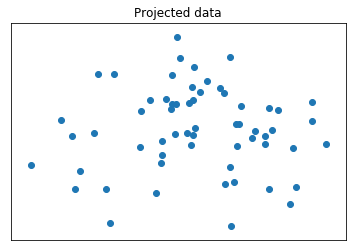

In [108]:
# Plot result
fig = plt.figure()
ax1 = fig.add_subplot(111)
y0 = Y[:, 0]
y1 = Y[:, 1]
ax1.scatter(y0,y1)
plt.axis('tight')
plt.xticks([]), plt.yticks([])
plt.title('Projected data') 

# How to get weights of a new element

In [109]:
#### Neighbors search for a new added shape 
# we will implement K-nearest neighbor search
def knn_new(X, K, x_new, t=2.0, dist_metric="euclidean", algorithm="ball_tree"):
    """ compute the neighborhood matrix

    Keyword arguments:
        X: np.array of data, each row(not column) is associated with one car. (A car is represented by a vector)
        K: number of neighbors to seek for each element (the element itself is excluded)
        dist_metric: with which metric to compute the distances
        algorithm: which which algorithm to use

    return:
        the neighborhood matrix
    """

    n, p = X.shape  # n: number of elements, p: dimension (number of data per element)

    knn = neighbors.NearestNeighbors(K + 1, metric=dist_metric, algorithm=algorithm).fit(X)
    nbors = knn.kneighbors([x_new],K + 1, return_distance=False)  # return k nearest neighbours of each member of X, nbors is array of indices 

    return (nbors[:, 1:])  # neighborhood matrix first one is the point itself, which should be excluded

In [110]:
# example of a new car shape
# knn_new: neighbors of the new shpae in the manifold space 
x_new = np.ones(dim_sample)
x_new[0:m] = 0
np.random.shuffle(x_new) 
knn_new = knn_new(X,K,x_new)[0] #knn_new(X,K,x_new)is a tuple with one element an array
print(knn_new)

[53  1 56 24 22 45 49 18]


In [111]:
#### calculation of reconstruction weights
def get_weights_new(x_new, knn_new, K, reg=0.001):
    """ compute the weight matrix

    Keyword arguments:
        x_new: a new vector representing a new car shape
        knn_new: neighborhood of the new car shape
        reg: avoid the covariance matrix to be singular #regularizer
        K: number of neighbours selected for each car

    return:
        the vector of weights for neighboring data points
    """
    
    X_bors = X[knn_new[0:K], :] - x_new  # Gi in MLLE paper, X[i] = X[i,:] ith row of X
    cov_nbors = np.dot(X_bors, X_bors.T)

    # regularization terms
    trace = np.trace(cov_nbors)
    if trace > 0:
        R = reg * trace
    else:
        R = reg
    cov_nbors.flat[::K + 1] += R  # [::K+1] -> every K+1 step. Allows adding only on trace
    weights = linalg.solve(cov_nbors, np.ones(K).T, sym_pos=True)  # solution to cov_nbors*weights = 1
        # optimal solution to min(cov_nbors*W)

        # normalizing
    weights = weights / weights.sum()

    return (weights)

In [112]:
w_new = get_weights_new(x_new, knn_new, K)
print(w_new)

[0.12643515 0.12620797 0.12561169 0.12651592 0.12355932 0.12369786
 0.12436117 0.12361092]


# Fast evaluation of the drag coefficient of a new car shape

In [113]:
# example coefficents dataset of original 60 car models
Cds = 0.2*np.random.random(60) + 0.2
for i, Cd in enumerate(Cds): # no need to know the number of the data in the array
    Cd = round(Cd, 3)
    Cds[i] = Cd
print(Cds)

[0.383 0.377 0.309 0.258 0.201 0.313 0.395 0.225 0.326 0.222 0.238 0.267
 0.307 0.312 0.221 0.338 0.24  0.301 0.257 0.38  0.287 0.345 0.246 0.383
 0.377 0.372 0.367 0.204 0.309 0.291 0.32  0.33  0.251 0.283 0.298 0.248
 0.334 0.28  0.377 0.242 0.335 0.325 0.277 0.359 0.275 0.293 0.25  0.231
 0.263 0.333 0.306 0.392 0.304 0.365 0.222 0.372 0.215 0.298 0.299 0.371]


In [114]:
# calculation of the drag coefficient of the new car
Cds_nn = np.zeros(K) # drag coefficients of the nearest neighbours
for i in range(K):
    Cds_nn[i] = Cds[knn_new[i]]
print(Cds_nn)
Cd_new = round(np.dot(w_new, Cds_nn),3)
print(Cd_new)

[0.365 0.377 0.215 0.377 0.246 0.293 0.333 0.257]
0.308


In [115]:
print(661*7/12*6/60)

38.55833333333333
